# Faster R-CNN Training using Tensorflow
___

# 1. Install Library
### 1.A. Install Tensorflow

In [ ]:
pip install tensorflow_gpu==1.15

### 1.B. Install Other Library & Clone Tensorflow Model

In [ ]:
!apt-get install protobuf-compiler python-pil python-lxml python-tk
!pip install Cython tf_slim
!pip install -q pycocotools
!pip install -q Cython contextlib2 pillow lxml matplotlib

!git clone https://github.com/tensorflow/models.git

### 1.C. Build Tensorflow Model Builder

In [4]:
%cd /content/models/research
!protoc object_detection/protos/*.proto --python_out=.
%set_env PYTHONPATH=/content/models/research:/content/models/research/slim

import os
os.environ['PYTHONPATH'] += ":/content/models"

import sys
sys.path.append("/content/models")
!python object_detection/builders/model_builder_test.py

# 2. Prepare Dataset
### 2.A Upload and extract dataset.
- upload `dataset.zip` using this script,
- `dataset.zip` is created by running `dataset_builder.ipynb` from this repository ([ObjectDetection-DatasetPreparation](http://github.com/Muhammad-Yunus/ObjectDetection-DatasetPreparation)) in your local computer.

In [61]:
%cd /content

import shutil
from zipfile import ZipFile
from google.colab import files
from os import path

print("Upload `dataset.zip` to colab :")
uploaded = files.upload()
  
for fileName, data in uploaded.items():
  with open('dataset.zip', 'wb') as f:
    f.write(data)
    f.close()
    print('saved dataset (.zip) file ' + fileName)

ds = ZipFile(fileName)
ds.extractall()
os.remove(fileName)
print('Extracted zip file ' + fileName)

/content
Upload `dataset.zip` to colab :


Saving dataset.zip to dataset.zip
saved dataset (.zip) file dataset.zip
Extracted zip file dataset.zip


### 2.B. Prepare Dataset 
- Convert XML PASCAL VOC to CSV
- Create TF_Record from generated CSV

In [71]:
%cd /content/dataset

!python xml_to_csv.py

/content/dataset
Successfully converted xml to csv.
Successfully converted xml to csv.


- edit `class_text_to_int()` function in `generated_tfrecord.py` with label and index label we have.

In [ ]:
%cd /content/dataset

!python generate_tfrecord.py --csv_input=data/train_labels.csv  --output_path=data/train.record --image_dir=images/train

!python generate_tfrecord.py --csv_input=data/test_labels.csv  --output_path=data/test.record --image_dir=images/test

# 3. Download pretrained model

- Pretrained model (Tensorflow 1 Model Zoo) : [[tensorflow github](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf1_detection_zoo.md)]


In [64]:
%cd /content/dataset
%rm -rf models

%mkdir models
%mkdir models/inference_graph

/content/dataset


In [65]:
%cd /content/dataset/models

import os
import shutil
import glob
import urllib.request
import tarfile

MODEL = 'faster_rcnn_inception_v2_coco_2018_01_28'
MODEL_FILE = MODEL + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
DEST_DIR = 'faster_rcnn_inception_v2'

with urllib.request.urlopen(DOWNLOAD_BASE+MODEL_FILE) as response, open(MODEL_FILE, 'wb') as out_file:
  shutil.copyfileobj(response, out_file)

tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

os.remove(MODEL_FILE)
if (os.path.exists(DEST_DIR)):
  shutil.rmtree(DEST_DIR)
os.rename(MODEL, DEST_DIR)

/content/dataset/models


# 4. Edit Config File
- copy config model to `data/` folder

In [66]:
CONFIG_NAME = "faster_rcnn_inception_v2_coco.config"
shutil.copy(
    "/content/models/research/object_detection/samples/configs/" + CONFIG_NAME, 
    "/content/dataset/data/")

'/content/dataset/data/faster_rcnn_inception_v2_coco.config'

- open & edit config file, 
- 
```
fine_tune_checkpoint: "/Path to the pre-trained models/model.ckpt"
```
- 
```
train_input_reader: {
  tf_record_input_reader {
  input_path: "/Path to the tfrecord/train.record"
  }
  label_map_path: "/Path to label map/object-detection.pbtxt"
}
```
- 
```
eval_input_reader: {
tf_record_input_reader {
input_path: "/Path to the tfrecord/test.record"
}
label_map_path: "/Path to label map/object-detection.pbtxt"
}
```
- change  `model`>`faster_rcnn`>`num_classes` to number of class on uploaded dataset.
- change `train_config`>`num_steps` to 20000

# 5. Train model
Make and set train directory num_train_steps and num_eval_steps values to change train and eval steps in training process.



In [68]:
!cp /content/models/research/object_detection/legacy/train.py /content/models/research/object_detection

In [80]:
%cd /content/models/research/object_detection/
%rm -rf training/*

!python train.py \
  --logtostderr \
  --train_dir=training/ \
  --pipeline_config_path=/content/dataset/data/faster_rcnn_inception_v2_coco.config

Streaming output truncated to the last 5000 lines.
INFO:tensorflow:global step 7508: loss = 0.0210 (0.156 sec/step)
I0213 16:55:00.775731 139806407255936 learning.py:512] global step 7508: loss = 0.0210 (0.156 sec/step)
INFO:tensorflow:global step 7509: loss = 0.0291 (0.173 sec/step)
I0213 16:55:00.950285 139806407255936 learning.py:512] global step 7509: loss = 0.0291 (0.173 sec/step)
INFO:tensorflow:global step 7510: loss = 0.0228 (0.175 sec/step)
I0213 16:55:01.126521 139806407255936 learning.py:512] global step 7510: loss = 0.0228 (0.175 sec/step)
INFO:tensorflow:global step 7511: loss = 0.0567 (0.156 sec/step)
I0213 16:55:01.284325 139806407255936 learning.py:512] global step 7511: loss = 0.0567 (0.156 sec/step)
INFO:tensorflow:global step 7512: loss = 0.0400 (0.171 sec/step)
I0213 16:55:01.456530 139806407255936 learning.py:512] global step 7512: loss = 0.0400 (0.171 sec/step)
INFO:tensorflow:global step 7513: loss = 0.0150 (0.169 sec/step)
I0213 16:55:01.627006 139806407255936 l

# 5. Tensorboard Training Visualisation

In [82]:
%cd /content/models/research/object_detection/training/
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

/content/models/research/object_detection/training
--2021-02-13 17:07:01--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 35.171.116.247, 34.205.198.58, 54.145.36.98, ...
Connecting to bin.equinox.io (bin.equinox.io)|35.171.116.247|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.1’

ngrok-stable-linux- 100%[===================>]  13.13M  47.3MB/s    in 0.3s    

2021-02-13 17:07:01 (47.3 MB/s) - ‘ngrok-stable-linux-amd64.zip.1’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
replace ngrok? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ngrok                   


In [83]:
LOG_DIR = '/content/models/research/object_detection/training/'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [104]:
get_ipython().system_raw('./ngrok http 6006 &')

In [105]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://ca3a346f1dd7.ngrok.io


# 6 Tensor Board Eval Visualization

In [108]:
%cd /content/models/research/object_detection/
!cp /content/models/research/object_detection/legacy/eval.py /content/models/research/object_detection

/content/models/research/object_detection


In [113]:
!pip install lvis

In [ ]:
!python eval.py \
  --logtostderr \
  --pipeline_config_path=/content/dataset/data/faster_rcnn_inception_v2_coco.config \
  --checkpoint_dir=training/ \
  --eval_dir=eval/

Instructions for updating:
Use object_detection/model_main.py.
W0213 18:11:55.609905 140057236469632 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/absl/app.py:251: main (from __main__) is deprecated and will be removed in a future version.
Instructions for updating:
Use object_detection/model_main.py.
INFO:tensorflow:Reading unweighted datasets: ['/content/dataset/data/test.record']
I0213 18:11:55.634628 140057236469632 dataset_builder.py:163] Reading unweighted datasets: ['/content/dataset/data/test.record']
INFO:tensorflow:Reading record datasets for input file: ['/content/dataset/data/test.record']
I0213 18:11:55.635586 140057236469632 dataset_builder.py:80] Reading record datasets for input file: ['/content/dataset/data/test.record']
INFO:tensorflow:Number of filenames to read: 1
I0213 18:11:55.635710 140057236469632 dataset_builder.py:81] Number of filenames to read: 1
Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length

In [115]:
LOG_DIR = '/content/models/research/object_detection/eval/'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6007 &'
    .format(LOG_DIR)
)

TensorBoard 1.15.0 at http://c89b25a93ab4:6007/ (Press CTRL+C to quit)
^C


In [ ]:
get_ipython().system_raw('./ngrok http 6007 &')

In [ ]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

# 6. Export trained model

Export trained model with highest step number in filename.

In [117]:
%cd /content/models/research/object_detection
%rm -rf inference_graph/*

!python export_inference_graph.py \
  --input_type image_tensor \
  --pipeline_config_path /content/dataset/data/faster_rcnn_inception_v2_coco.config \
  --trained_checkpoint_prefix /content/models/research/object_detection/training/model.ckpt-10000 \
  --output_directory /content/dataset/models/inference_graph

/content/models/research/object_detection
Instructions for updating:
Please use `layer.__call__` method instead.
W0213 18:11:09.429981 140373094274944 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tf_slim/layers/layers.py:2802: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.
INFO:tensorflow:Scale of 0 disables regularizer.
I0213 18:11:10.648009 140373094274944 regularizers.py:99] Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
I0213 18:11:10.778941 140373094274944 regularizers.py:99] Scale of 0 disables regularizer.
INFO:tensorflow:depth of additional conv before box predictor: 0
I0213 18:11:10.779458 140373094274944 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0213

# 7. Test Model (Inferencing)
- Upload image test

In [90]:
%cd /content

from google.colab import files
from os import path

uploaded = files.upload()
  
for name, data in uploaded.items():
  with open('image1.jpg', 'wb') as f:
    f.write(data)
    f.close()
    print('saved file ' + name)

/content


Saving batman_13.jpg to batman_13.jpg
saved file batman_13.jpg


- upload arial font (`arial.ttf`) from cloned repo ([ObjectDetection-DatasetPreparation](http://github.com/Muhammad-Yunus/ObjectDetection-DatasetPreparation)) using script below,

In [102]:
uploaded = files.upload()
  
for name, data in uploaded.items():
  with open('/content/models/research/object_detection/utils/arial.ttf', 'wb') as f:
    f.write(data)
    f.close()
    print('saved file ' + name)

Saving arial.ttf to arial.ttf
saved file arial.ttf


- open `/content/models/research/object_detection/utils/visualization_utils.py` and navigate to line `212`, change font size to a proper value (e.g/ 50).
    ```
    try:
      font = ImageFont.truetype('arial.ttf', 50)
    except IOError:
      font = ImageFont.load_default()
    ```

- predict on `image1.jpg`

/content/models/research/object_detection
IMAGE SIZE : (720, 1280)


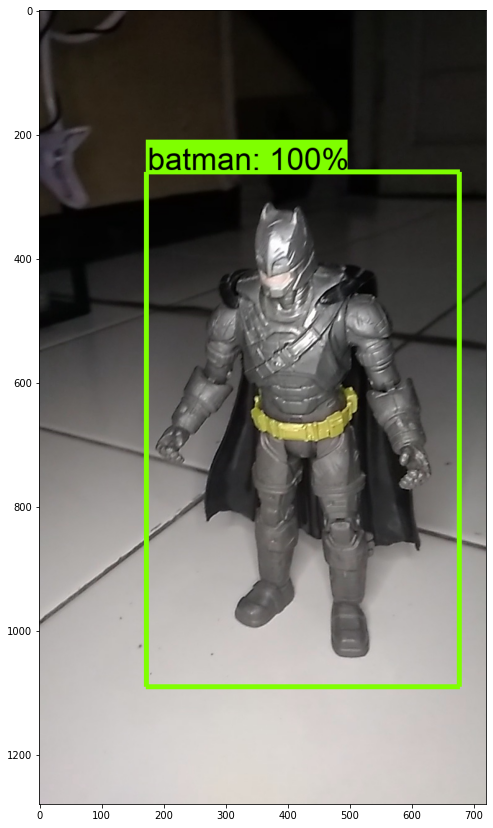

In [103]:
%cd /content/models/research/object_detection

import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

#if tf.__version__ < '1.4.0':
#  raise ImportError('Please upgrade your tensorflow installation to v1.4.* or later!')
  
  
# This is needed to display the images.
%matplotlib inline


from utils import label_map_util

from utils import visualization_utils as vis_util
import importlib
importlib.reload(vis_util)

# What model to download.
# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = '/content/dataset/models/inference_graph' + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('/content/dataset/data', 'object-detection.pbtxt')

NUM_CLASSES = 2

detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')
    
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)



def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  print("IMAGE SIZE :",image.size)
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)



# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = '/content/'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 2) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (8, 17)


def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict




for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)
  

# 8. Zip  & Download Inference Graph

In [ ]:
%cd /content/dataset/models
!zip -r inference_graph.zip inference_graph

from google.colab import files
files.download("inference_graph.zip")

___
# Source :
- https://muchamadsyaiffudin.medium.com/object-detection-with-custom-dataset-faster-rcnn-on-google-colab-33b373a625eb
- https://colab.research.google.com/drive/1skc-BJ6HzuaIRbi3diP86lRnCTcNCond?usp=sharing

In [ ]:
from google.colab import drive
drive.mount('/content/models/research/drive')

Mounted at /content/models/research/drive


**RUN WEBCAM**

In [98]:
%cd /content/models/research/object_detection

import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

#if tf.__version__ < '1.4.0':
#  raise ImportError('Please upgrade your tensorflow installation to v1.4.* or later!')
  
  
# This is needed to display the images.
%matplotlib inline


from utils import label_map_util

from utils import visualization_utils as vis_util


# What model to download.
# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = '/content/dataset/models/inference_graph' + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('/content/dataset/data/', 'object-detection.pbtxt')

NUM_CLASSES = 2

detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')
     
    
    
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)



def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)



# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = '/content/'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 2) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)


def run_inference_for_single_image(image, graph):
    if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
    image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

    # Run inference
    output_dict = sess.run(tensor_dict,
                            feed_dict={image_tensor: np.expand_dims(image, 0)})

    # all outputs are float32 numpy arrays, so convert types as appropriate
    output_dict['num_detections'] = int(output_dict['num_detections'][0])
    output_dict['detection_classes'] = output_dict[
        'detection_classes'][0].astype(np.uint8)
    output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
    output_dict['detection_scores'] = output_dict['detection_scores'][0]
    if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict




/content/models/research/object_detection


In [ ]:
    import cv2
cap = cv2.VideoCapture(0)

with detection_graph.as_default():
    with tf.Session() as sess:
        ops = tf.get_default_graph().get_operations()
        all_tensor_names = {output.name for op in ops for output in op.outputs}
        tensor_dict = {}
        for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
          ]:
            tensor_name = key + ':0'
            if tensor_name in all_tensor_names:
                tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
        while True:
            ret, image_np = cap.read()
            # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
            image_np_expanded = np.expand_dims(image_np, axis=0)
            # Actual detection.
            output_dict = run_inference_for_single_image(image_np, detection_graph)
            # Visualization of the results of a detection.
            vis_util.visualize_boxes_and_labels_on_image_array(
              image_np,
              output_dict['detection_boxes'],
              output_dict['detection_classes'],
              output_dict['detection_scores'],
              category_index,
              instance_masks=output_dict.get('detection_masks'),
              use_normalized_coordinates=True,
              line_thickness=8)
            cv2.imshow('object detection', cv2.resize(image_np, (800,600)))
            if cv2.waitKey(1) & 0xFF == ord('q'):
                cap.release()
                cv2.destroyAllWindows()
                break